# Test Notebook for solvers Algorithms

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio

# Operator imports
import llops as yp
import llops.operators as ops
from llops import solvers
from llops.solvers import objectivefunctions, regularizers
import llops.simulation as sim

In [2]:
ops.setDefaultBackend('arrayfire') # arrayfire or numpy
ops.setDefaultDatatype('complex32')

global_dtype = yp.config.default_dtype
global_backend = yp.config.default_backend

# Generate Forward Model For Convolutional System with Windowing

<IPython.core.display.Javascript object>


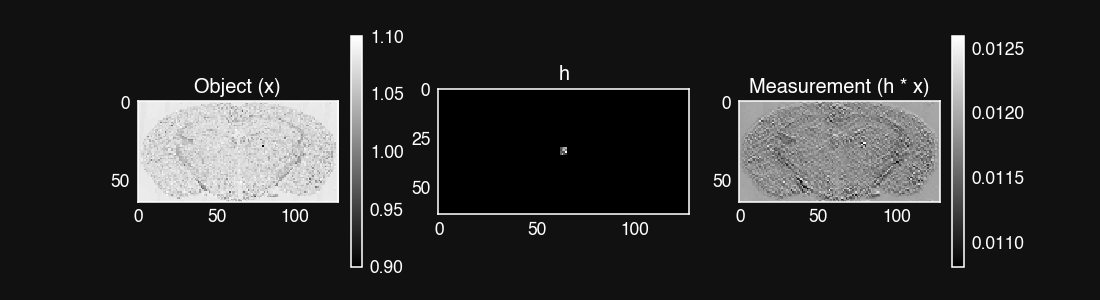

In [5]:
# Image size to simulate
image_size = np.array([32, 64]) * 2

# Create test object
brain = sim.testObject('brain', image_size, color_channel=2, dtype=global_dtype)
object_true = yp.changeBackend(brain, global_backend)

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(h))

A = ops.Convolution(h, mode='circular')
y = A * object_true

# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.colorbar()
plt.subplot(132)
plt.imshow(np.abs(np.asarray(h)), cmap='gray')
plt.title('h')
plt.subplot(133)
plt.imshow((np.abs(np.asarray(y))).reshape(image_size), cmap='gray')
plt.title('Measurement (h * x)');
plt.colorbar()

# Reconstructions

## L2 Objective

In [6]:
# Generate Objective
objective = objectivefunctions.L2(A, y)

# Generate Object
x = yp.ones(objective.N, global_dtype, global_backend)

# Render latex
objective.latex()

<IPython.core.display.Latex object>

### Gradient Descent

<IPython.core.display.Javascript object>


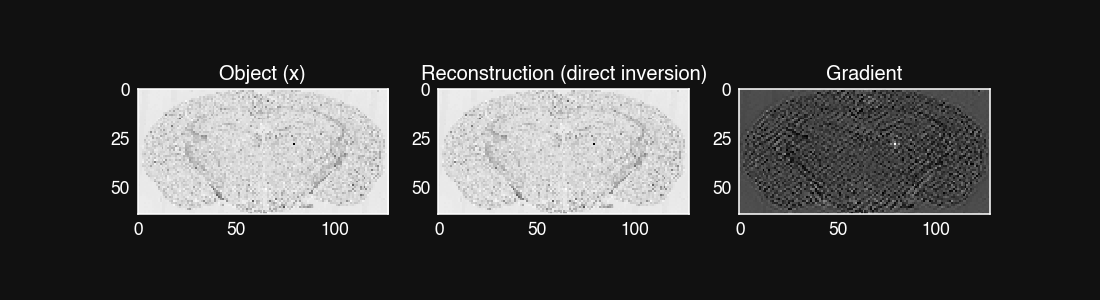

In [7]:
# Show object and h
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(np.asarray(object_true)), cmap='gray')
plt.title('Object (x)')
plt.subplot(132)
plt.imshow(np.abs(A.inv * y), cmap='gray')
plt.title('Reconstruction (direct inversion)')
plt.subplot(133)
plt.imshow(yp.abs(objective.gradient(x)), cmap='gray')
plt.title('Gradient');

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    5.72e-01    |       0.00       |    0.00e+00    |  211.4 MB /    0.7 MB  |
|   50   |    4.76e-07    |       0.72       |    4.58e-05    |  211.5 MB /    0.8 MB  |
|  100   |    4.93e-08    |       1.33       |    8.39e-05    |  211.5 MB /    0.8 MB  |
|  150   |    1.98e-08    |       1.98       |    2.29e-05    |  210.1 MB /    0.8 MB  |
|  200   |    9.48e-09    |       2.66       |    0.00e+00    |  209.6 MB /    0.8 MB  |
|  250   |    5.56e-09    |       3.27       |    7.63e-06    |  209.6 MB /    0.8 MB  |
|  300   |    1.94e-09    |       3.89       |    1.53e-05    |  209.6 MB /    0.8 MB  |
|  350   |    4.21e-10    |       4.53       |    0.00e+00    |  209.6 MB /    0.8 MB  |
|  400   |    1.66e-10    |       5.14       |    7.63e-06    |  209.6 MB /    0.8 MB  |
|  450   |    9.97e-1

<IPython.core.display.Javascript object>


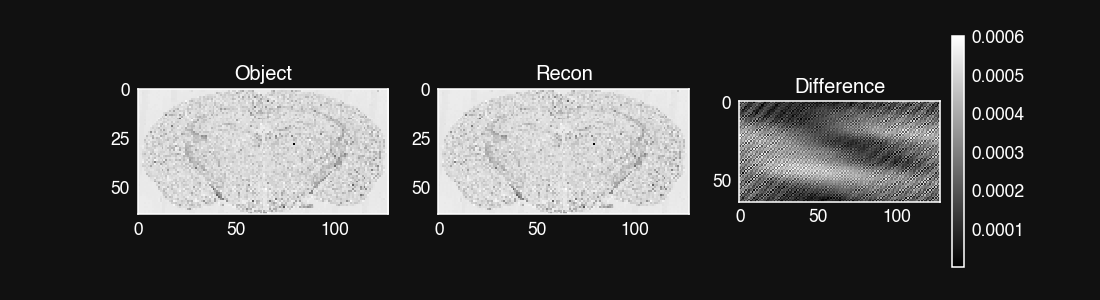

In [9]:
# Minimize objective using Gradient Descent
x_opt = solvers.GradientDescent(objective).solve(iteration_count=500, display_type='text', step_size=100, display_iteration_delta=50, 
                                                   use_nesterov_acceleration=True, nesterov_restart_enabled=True)
# Show object and psf
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(132)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(133)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')
plt.colorbar()

## Conjugate Gradient

In [10]:
x_opt = solvers.ConjugateGradient(A, y).solve(iteration_count=10, display_type='text', step_size=0.1, display_iteration_delta=1)

# Show object and psf
plt.figure(figsize=(11,3))
plt.subplot(131)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(132)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(133)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    5.72e-01    |       0.00       |    0.00e+00    |  213.7 MB /    0.7 MB  |
|    1   |    5.72e-01    |       0.01       |    0.00e+00    |  213.7 MB /    0.8 MB  |


RuntimeError: In function af::dim4 getOutDims(const af::dim4 &, const af::dim4 &, bool)
In file src/backend/common/ArrayInfo.cpp:180
Invalid dimension for argument 1
Expected: ldims == rdims


# ISTA/FISTA

Minimizing function:


<IPython.core.display.Latex object>

|  Iter  |      Cost      | Elapsed time (s) |  Norm of Step  | Memory Usage (CPU/GPU) |
+ ------ + -------------- + ---------------- + -------------- + ---------------------- +
|    0   |    5.72e-01    |       0.00       |    0.00e+00    |  188.8 MB /    0.9 MB  |
|   50   |    5.72e-01    |       0.69       |    1.08e-04    |  190.3 MB /    1.0 MB  |
|  100   |    5.72e-01    |       1.27       |    1.08e-04    |  186.1 MB /    1.0 MB  |
|  150   |    5.72e-01    |       1.86       |    1.08e-04    |  186.1 MB /    1.0 MB  |
|  200   |    5.72e-01    |       2.46       |    1.08e-04    |  186.2 MB /    1.0 MB  |
|  250   |    5.72e-01    |       3.04       |    1.08e-04    |  186.2 MB /    1.0 MB  |
|  300   |    5.71e-01    |       3.62       |    1.08e-04    |  186.2 MB /    1.0 MB  |
|  350   |    5.71e-01    |       4.21       |    1.08e-04    |  186.2 MB /    1.0 MB  |
|  400   |    5.71e-01    |       4.80       |    1.08e-04    |  186.2 MB /    1.0 MB  |
|  450   |    5.71e-0

<IPython.core.display.Javascript object>


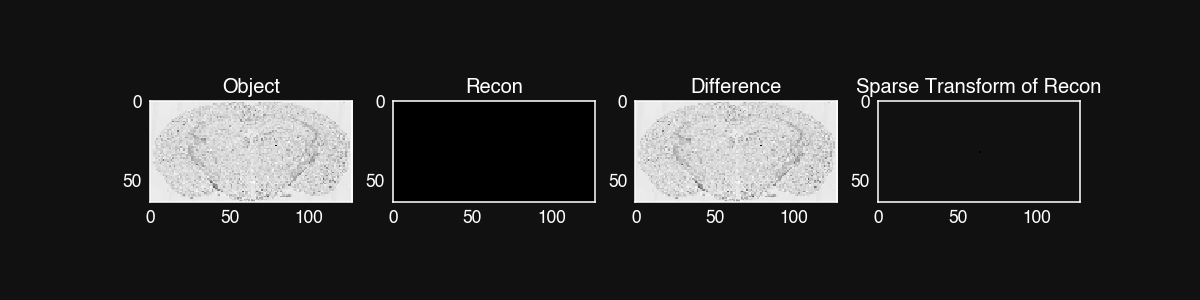

In [11]:
# Define regularizer function
reg_type = 'fourier'
if reg_type is 'wavelet':
    reg = regularizers.WaveletSparsity(image_size, wavelet_type='haar')
    sparse_op = reg.sparse_op
elif reg_type is 'fourier':
    sparse_op = ops.FourierTransform(image_size)
    reg = ops.L1Norm(image_size) * sparse_op

# Generate objective function
objective_reg = objective + 1e-3 * reg

# Solve using FISTA/ISTA
x_opt = solvers.Fista(objective_reg).solve(iteration_count=500, display_type='text', step_size=1e-2, display_iteration_delta=50, 
                                            normalize_step_size=True, use_nesterov_acceleration=False, nesterov_restart_enabled=False, let_diverge=True)

# Show object and psf
plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')
plt.subplot(142)
plt.imshow(np.abs(x_opt).reshape(image_size), cmap='gray')
plt.title('Recon')
plt.subplot(143)
plt.imshow(np.abs(x_opt - object_true).reshape(image_size), cmap='gray')
plt.title('Difference')
plt.subplot(144)
x_s = yp.changeBackend(sparse_op * x_opt, 'numpy')
x_s *= np.abs(x_s) > 1e-7
plt.imshow(np.log(np.abs(x_s).reshape(sparse_op.M)))
plt.title('Sparse Transform of Recon');